# RK2-FB Analysis from Shchepetkin

Consider a simple model problem:
\begin{align*}
    \frac{\partial \zeta}{\partial t} &= -c \frac{\partial u}{\partial x}, \\
    \frac{\partial u}{\partial t} &= -c \frac{\partial \zeta}{\partial x}.
\end{align*}
Note that this is similar to the 1D linearized SWEs with the Coriolis term deleted.

With the goal of applying a von Neumann stability anaysis, we can apply a Fourier transform in $x$ to the above to get
\begin{align*}
    \frac{\partial \hat{\zeta}}{\partial t} &= -i \omega \hat{u}, \\
    \frac{\partial \hat{u}}{\partial t} &= -i \omega \hat{\zeta},
\end{align*}
where $\omega = ck$ for a given wavenumber $k$. Also, from now on, write $u = \hat{u}$ and $\zeta = \hat{\zeta}$ to ease notation.

Chose a time-step $\Delta t$ and let $\alpha = \omega\Delta t = ck\Delta t$. The RK2-FB algorithm for this system is then given by:
\begin{align*}
    \bar{\zeta}^{n+1} &= \zeta^n - i \alpha u^n \\
    \bar{u}^{n+1} &= u^n - i \alpha \left[ \beta\bar{\zeta}^{n+1} + (1 - \beta)\zeta^n \right] \\
    & \\
    \zeta^{n+1} &= \zeta^n - i \alpha \left( \frac{\bar{u}^{n+1} + u^n}{2} \right) \\
    u^{n+1} &= u^n - i \alpha \left( \frac{ \left( \varepsilon \zeta^{n+1} + (1 - \varepsilon)\bar{\zeta}^{n+1} \right) + \zeta^n }{2} \right),
\end{align*}
where $\beta$ and $\varepsilon$ are the tunable FB feedback coefficients.

In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline


# define relevent symbols 
#     _u = u^n, _zeta = \zeta^n
#     U = \bar{u}^{n+1}, ZETA = \bar{\zeta}^{n+1}
#     u = u^{n+1}, zeta = \zeta^{n+1}
_u, _zeta = symbols('u^n \zeta^n')
lam, alpha, beta, eps = symbols('lambda alpha beta varepsilon')

# define time-stepping scheme
ZETA = _zeta - I*alpha*_u
U = _u - I*alpha * ( beta*ZETA + (1-beta)*_zeta )

zeta = _zeta - I*alpha * (U + _u)/2
u = _u - I*alpha * ( ( eps*zeta + (1-eps)*ZETA ) + _zeta )/2

# simplify the expressions for zeta and u 
zeta  = zeta.simplify()
u = u.simplify()

Now, we have a system of linear equations in $\zeta^n$ and $u^n$. We can find the amplification matrix for the scheme by writing it in the form
$$ \mathbf{w}^{n+1} = G \mathbf{w}^n, $$
where $G$ is the amplification matrix and $\mathbf{w}^* = (\zeta^*, u^*)^T$.

We care about the amplification matrix $G$ as it follows from the above that $\mathbf{w}^n = G^n \mathbf{w}^0$. In turn, it follows that the solution $\mathbf{w}^n$ is bounded as $ n \to \infty$ if and only if $||G^n||$ is bounded as $n \to \infty$.

In [2]:
# create the amplification matrix G
_w = [_zeta, _u]
w = [zeta, u]
G, _ = linear_eq_to_matrix(w, _w)

G

Matrix([
[                   1 - alpha**2/2,                 I*alpha**3*beta/2 - I*alpha],
[I*alpha**3*varepsilon/4 - I*alpha, alpha**4*beta*varepsilon/4 - alpha**2/2 + 1]])

Normally, we would now be interested in the eigenvalues of $G$ given that it can be shown that as long as $G$ is diagonalizable, then $||G^n||$ is bounded if and only if each eigenvalue $\lambda$ of $G$ is such that $|\lambda| \leq 1$.

However, we are first interesting in chosing the "optimal" FB feedback coefficients $\beta$ and $\varepsilon$.

To do this, we observe that we can write the orignal, Fourier transformed, system as
$$ \frac{\partial}{\partial t}\begin{pmatrix} \zeta \\ u \end{pmatrix} = \begin{pmatrix} 0 & -i\omega \\ -i\omega & 0 \end{pmatrix} \begin{pmatrix} \zeta \\ u \end{pmatrix}. $$

One can show that the solution to the system is
$$ \begin{pmatrix} \zeta(t) \\ u(t) \end{pmatrix} = e^{t \begin{pmatrix} 0 & -i\omega \\ -i\omega & 0 \end{pmatrix}} \begin{pmatrix} \zeta(0) \\ u(0) \end{pmatrix}, $$
and that eigenvalues of the matrix exponential above are
$$ \lambda = e^{\pm i \omega t}. $$

That is, the eigenvalues of the amplification matrix in the exact solution are $ \lambda = e^{ \pm i \omega t} $. We would like the eigenvalues of our approximate amplification matrix $G$ to be the same, or as close as possible to $ e^{\pm i \omega t} $.

Consider the solution to the system after exatly one time-step, at time $t = \Delta t$. We want the eigenvalues of $G$ to approximate $e^{\pm i \omega \Delta t} = e^{\pm i \alpha}$. 

To do this, we first calculate the characteristic polynomial $p(\lambda) = \text{det}(G - \lambda I)$ of $G$:

In [3]:
p = G.charpoly(lam).as_expr()
p

alpha**4*beta*varepsilon/4 - alpha**4*beta/2 - alpha**4*varepsilon/4 + alpha**4/4 + lambda**2 + lambda*(-alpha**4*beta*varepsilon/4 + alpha**2 - 2) + 1

Next, we substitute in the desired value $\lambda = e^{\pm i \alpha}$ into the characteristic polynomial $p(\lambda)$ of $G$.

Now, if $e^{\pm i \alpha}$ was a true eigenvalue of $G$, then we would have
$$ p\left(e^{\pm i \alpha}\right) = 0. $$
This is not the case, so we want to choose values for $\beta$ and $\epsilon$ that get us as close as possible as $\alpha \to 0$ (i.e. as $\Delta t \to 0$).

So, expand the characteristic polynomial $p\left(e^{\pm i \alpha}\right)$ as a Taylor series in $\alpha$ centered at $0$:

In [4]:
exactPplus = p.subs([(lam, exp(I*alpha))])
exactPminus = p.subs([(lam, exp(-I*alpha))])

series(exactPplus, alpha, 0, 7)

alpha**4*(-beta/2 - varepsilon/4 + 1/3) + alpha**5*(-I*beta*varepsilon/4 + I/12) + alpha**6*(beta*varepsilon/8 - 2/45) + O(alpha**7)

In [5]:
series(exactPminus, alpha, 0, 7)

alpha**4*(-beta/2 - varepsilon/4 + 1/3) + alpha**5*(I*beta*varepsilon/4 - I/12) + alpha**6*(beta*varepsilon/8 - 2/45) + O(alpha**7)

So, we want that
$$\alpha^4 \left(-\frac{\beta}{2} - \frac{\varepsilon}{4} + \frac{1}{3}\right) \pm \alpha^5 \left(\frac{i\beta\varepsilon}{4} - \frac{i}{12}\right) + \alpha^6\left(\frac{\beta\varepsilon}{8} - \frac{2}{45}\right) + \mathcal{O}(\alpha^7) \approx 0. $$

We can chose $\varepsilon$ to eliminate the $\mathcal{O}(\alpha^4)$ term:

In [6]:
epsVal = nsimplify( solve(-beta/2 - eps/4 + 1/3, eps)[0] )
epsVal

4/3 - 2*beta

With
$$ \varepsilon = \frac{4}{3} - 2\beta, $$
the $\mathcal{O}(\alpha^4)$ term is eliminated. We then substitute this into the coefficent of the $\mathcal{O}(\alpha^5)$ term:

In [7]:
nsimplify( (beta*epsVal/4 - 1/12).expand() )

-beta**2/2 + beta/3 - 1/12

This has no real roots, so the best we can do is minimize the coefficient. It can be rewritten as 
$$ \frac{1}{2}\left( \beta - \frac{1}{3} \right)^2 + \frac{1}{36}, $$
so we chose
$$ \beta = \frac{1}{3}. $$
As a result we also get
$$ \varepsilon = \frac{2}{3}. $$

Now, we can plot the complex eigenvalues of the "optimal" amplification matrix $G$ as we vary $\alpha$.

In [8]:
a5coef = nsimplify( (beta*epsVal/4 - 1/12).expand() )

#a5coefFun = lambdify(beta, a5coef)
a5coefFun = lambda x: np.abs(-(x**2)/2 + x/3 - 1/12)
res = minimize(a5coefFun, 0)
res

      fun: 0.02777777777777781
 hess_inv: array([[1]])
      jac: array([-9.31322575e-10])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.33333333])

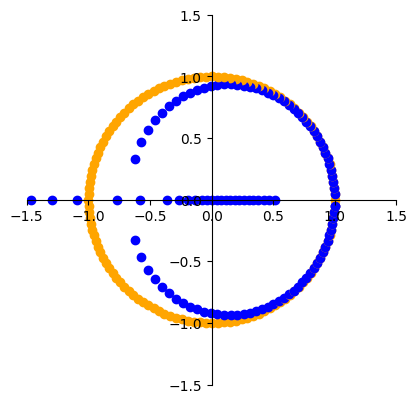

In [9]:
optP = p.subs([(beta, 1/3), (eps, 2/3)])


fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, alpha=1)
ax.add_artist(unitCircle)

for k in np.arange(-16.0, 16.0, 0.25):
    if k < 0 and k != 0:
        approx = complex(solve(optP.subs(alpha, k*pi/16), lam)[0])
    elif k != 0:
        approx = complex(solve(optP.subs(alpha, k*pi/16), lam)[1])
    # END if        
    exact = complex(exp(I*k*pi/16).evalf())
    
    ax.scatter(exact.real, exact.imag, color='orange')
    ax.scatter(approx.real, approx.imag, color='blue')
# END for

We note that the eigenvalues leave the unit circle at $\lambda = -1$ (this is when we lose stability). If we substitute $\lambda = -1$ into our "optimal" characteristic polynomial, we can find the maximum allowable value for $\alpha = ck\Delta t$.

In plain language, we are finding the first value for $\alpha$ for which the eigenvalues leave the unit circle, i.e. solving for $\alpha$ in
$$ p(-1) = 0. $$

In [10]:
solve(optP.subs([(lam, -1)]), alpha)

[-5.60503415377629, -2.14093253863854, 2.14093253863854, 5.60503415377629]

Therefore, we have that
$$ \alpha_{\text{max}} = 2.14093253863854 $$

Trying to find the largest $\alpha_\text{max}$ as in Shchepetkin:

In [11]:
alphOptP = p.subs([(lam, -1), (eps, epsVal)])
alphOptP

alpha**4*beta*(4/3 - 2*beta)/2 - alpha**4*beta/2 - alpha**4*(4/3 - 2*beta)/4 + alpha**4/4 - alpha**2 + 4

In [12]:
for expr in solve(alphOptP, alpha):
    fun = lambdify(beta, -1*expr)
    res = minimize(fun, 0)
    print(res)
    print('\n')

      fun: nan
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'NaN result encountered.'
     nfev: 2
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([0.])


      fun: nan
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'NaN result encountered.'
     nfev: 2
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([0.])


      fun: 0.03413673396899472
 hess_inv: array([[30262800.91743682]])
      jac: array([9.94466245e-06])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 21
     njev: 22
   status: 0
  success: True
        x: array([-1715.6884316])


      fun: -2.140932538638168
 hess_inv: array([[0.07599896]])
      jac: array([-3.01003456e-06])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.3333331])




<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2*sqrt(3)*sqrt(48*beta**2 - 32*beta + 7)/(12*beta**2 - 8*beta + 1) - 6/(12*beta**2 - 8*beta + 1))
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in sqrt
  return -sqrt(-2*sqrt(3)*sqrt(48*beta**2 - 32*beta + 7)/(12*beta**2 - 8*beta + 1) - 6/(12*beta**2 - 8*beta + 1))


In [14]:
alphOptP.subs([(beta, 1/3), (alpha, -2.140932538638168)])

1.18571819029967e-12